# 0.0. IMPORTS

In [2]:
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import matplotlib.pyplot   as plt
import inflection
import math
import pickle
import random              as rd
import warnings

from boruta                import BorutaPy
from IPython.display       import Image
from datetime              import datetime
from datetime              import timedelta
from matplotlib            import gridspec
from tabulate              import tabulate
from scipy                 import stats as ss
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model,verbose=False):

    mae_list = []
    mape_list =[]
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - timedelta(days=(k-1)*6*7)

        #filtering dateset

        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ] 

        #training and validation dataset
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str), 
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (20,8)
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


In [4]:
jupyter_settings()

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\Users\rauul\Anaconda3\envs\ds-em-producao\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [13]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance
# Assumimos uma assumption, onde farmacias que não contem competidor proximo, ao inves de retornar um valor NaN, retornar uma distancia maior que o valor max
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
# Se o valor == NaN, quer dizer que ou a loja nao tem competidores ou não tem uma data de registro de abertura da competição
# Assumption: será inserido o mês e o ano da data de registro da venda, pois na avaliação do algoritmo, esse atributo pode ser importantes para responder a alta ou baixa no valor de venda, nesse sentido, vamos assumir essa premissa para analisar os resultados
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central tedency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.1. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [17]:
aux = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

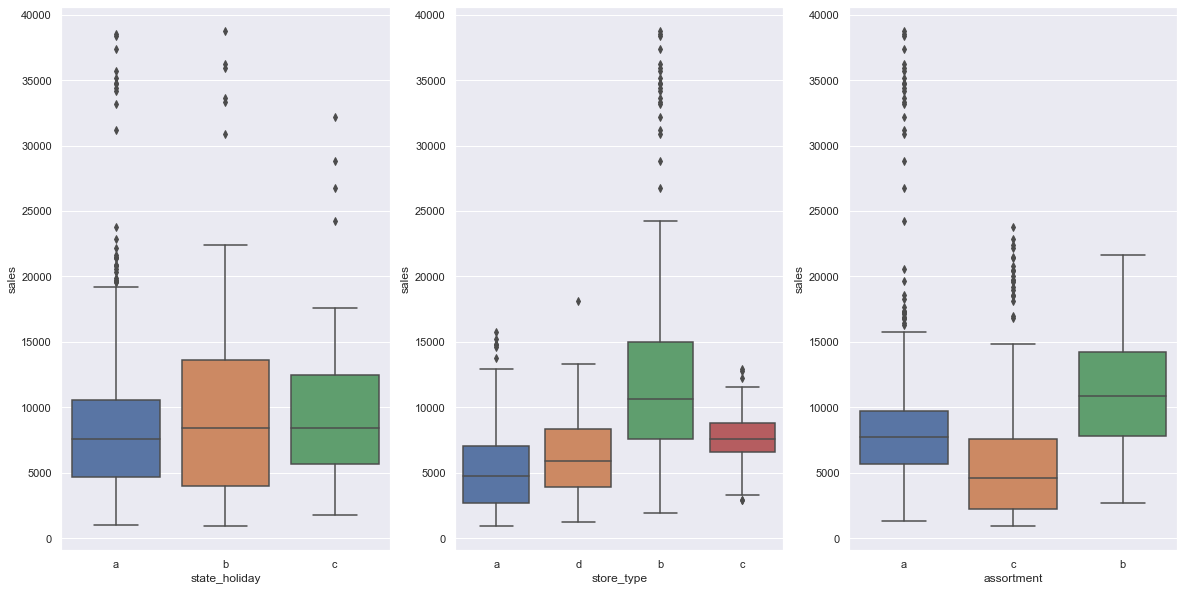

In [18]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

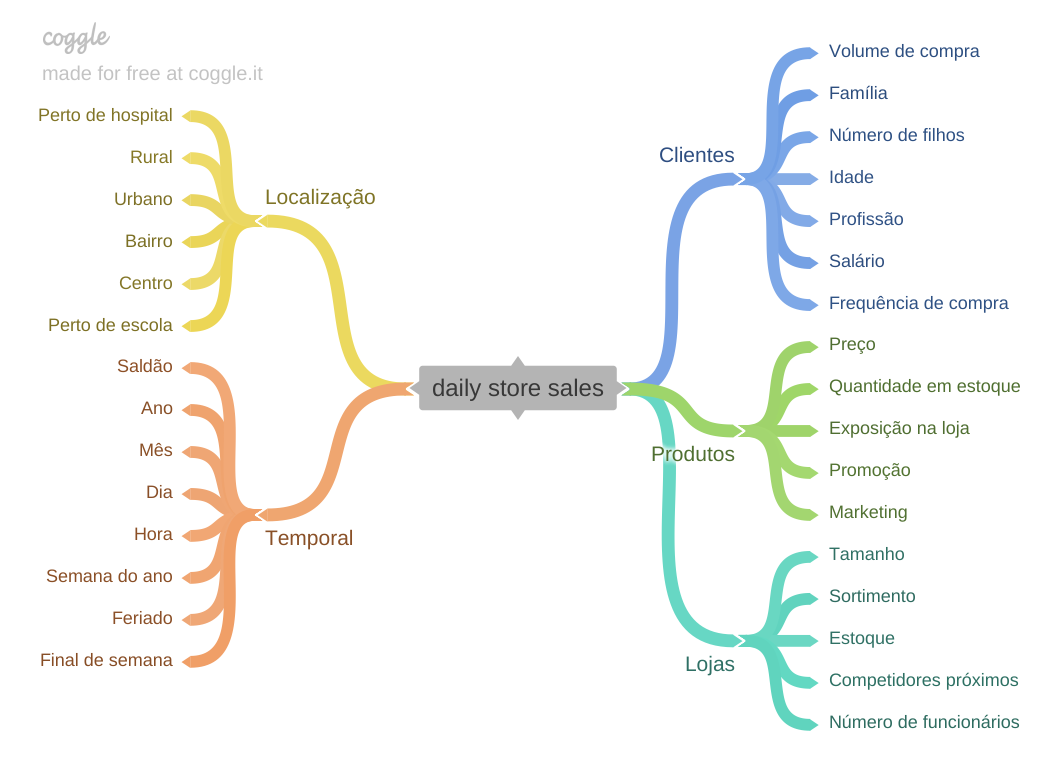

In [20]:
Image('img\MindMapHyphothesesRossman.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com competidores a mais tempo deveriam vender mais.

**6.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2. Hipóteses da Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais seus produtos na vitrine deveriam vender mais.

**3.** Lojas com preços menores nos produtos deveriam vender mais.

**4.** Lojas com preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses da Tempo

**1.** Lojas que mais fecham em feriados deveriam vender menos.

**2.** Lojas que permanecem abertas mais dias na semana deveriam vendem mais.

**3.** Lojas que abrem nos finais de semana deveriam vender menos.

**4.** Lojas que abrem durante o natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas deveriam vender mais no segundo semestro do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos durante feriados escolares.

### 2.2.4. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas que abrem durante o natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestro do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas que abrem nos finais de semana deveriam vender menos.

**12.** Lojas deveriam vender menos durante feriados escolares.

## 2.3. Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
#df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTERING VARIABLES

In [22]:
df3 = df2.copy()

## 3.1. Filtering rows

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering columns

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. EXPLORATION DATA ANALISYS

In [25]:
df4 = df3.copy()

## 4.1. Univariate Analisys

### 4.1.1. Response Variable

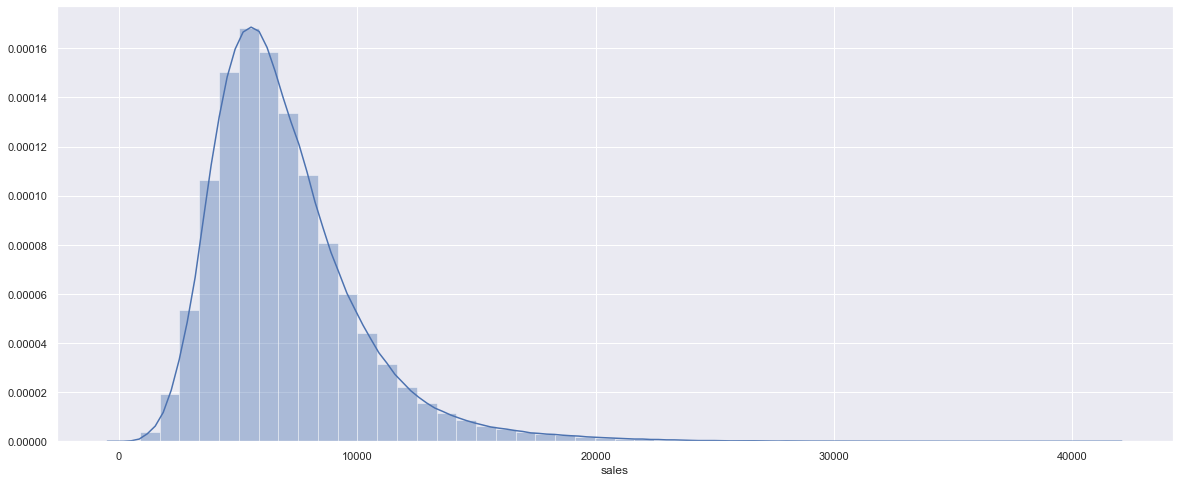

In [26]:
sns.distplot(df4['sales']);

### 4.1.1. Numerical Variable

In [27]:
num_attributes2 = df3.select_dtypes(include=['int64','float64'])

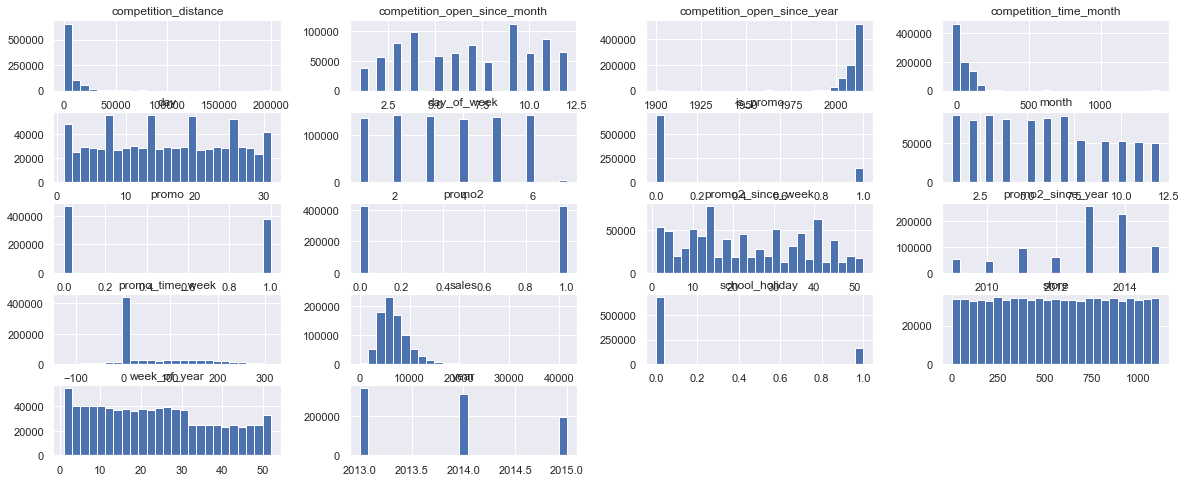

In [28]:
#Explicar cada plot, causa e efeito, uma resposta para um possível comportamento
num_attributes2.hist(bins=25);

### 4.1.1. Categorical Variable

In [29]:
cat_attributes2 = df3.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

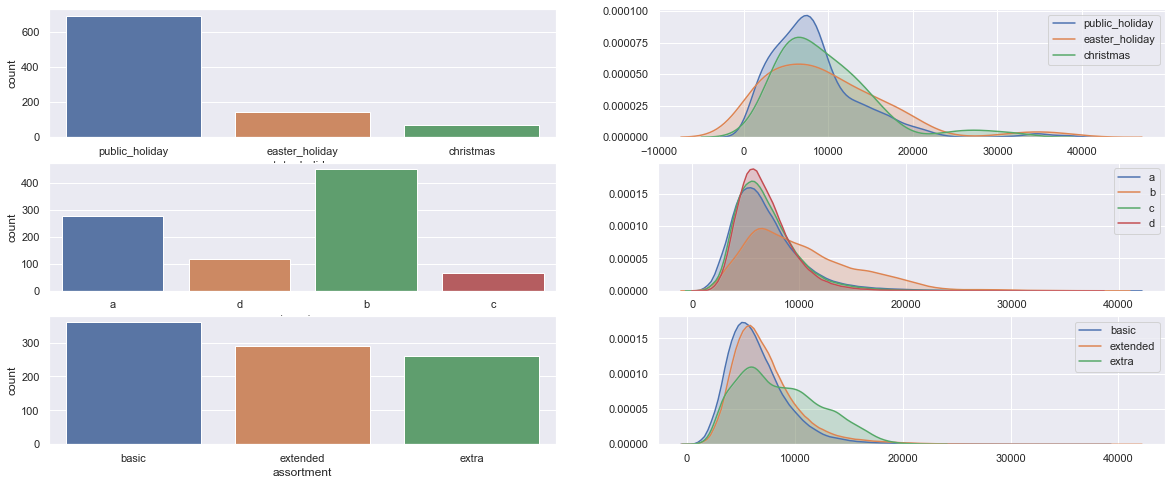

In [30]:
#state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analisys

### 4.2.1. Hyopotheses Validation

#### **H1.** Lojas com maior sortimento deveriam vender mais.
**True**

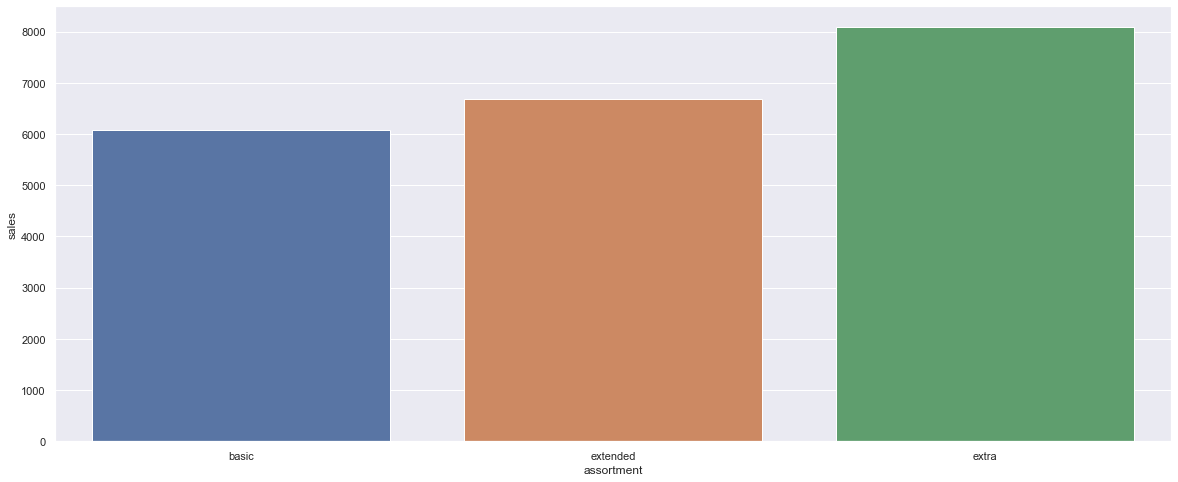

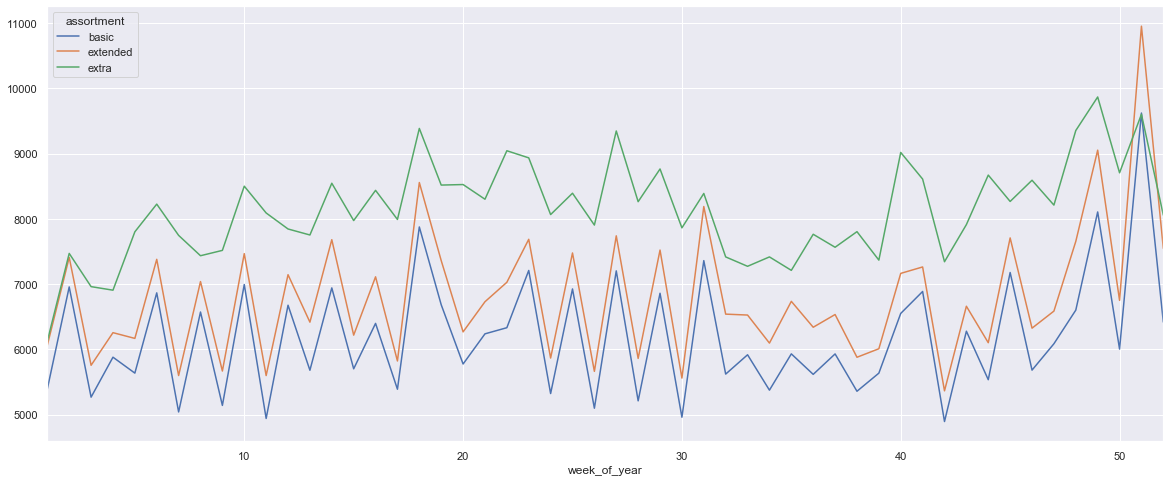

In [31]:
aux1 = df4[['assortment','sales']].groupby('assortment').median().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);

aux2 = df4[['week_of_year','assortment','sales']].groupby(['week_of_year','assortment']).median().reset_index()
aux2.pivot(index='week_of_year',columns='assortment',values='sales').plot();

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**False** A relação de venda com a distância de competidores não se correlacionam.

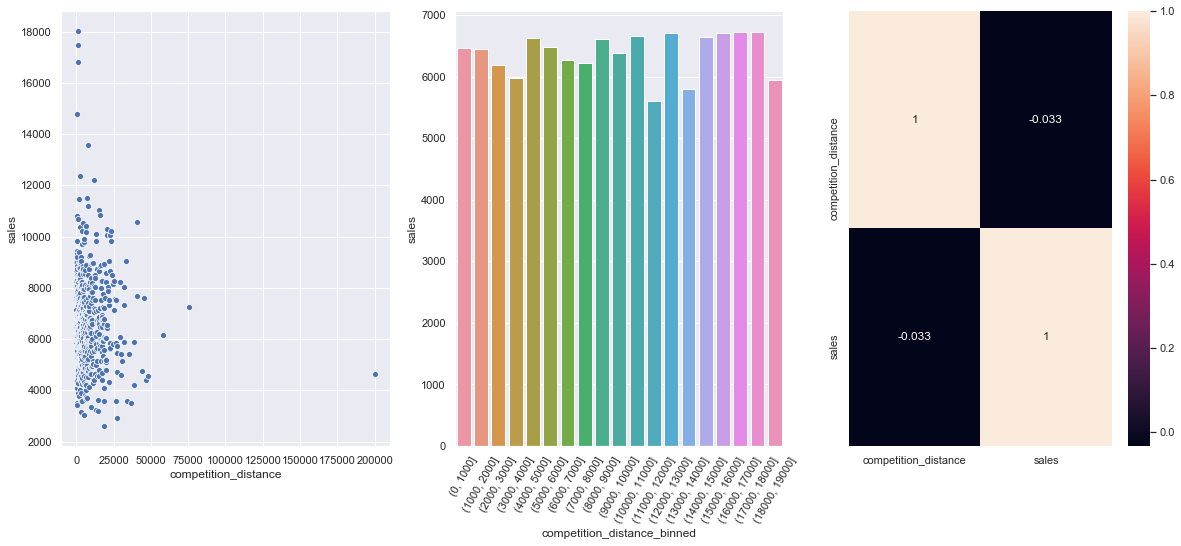

In [32]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').median().reset_index()

plt.subplot(1,3,2)
plt.xticks(rotation=60)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**False** Lojas com competidores a mais tempo vedem menos

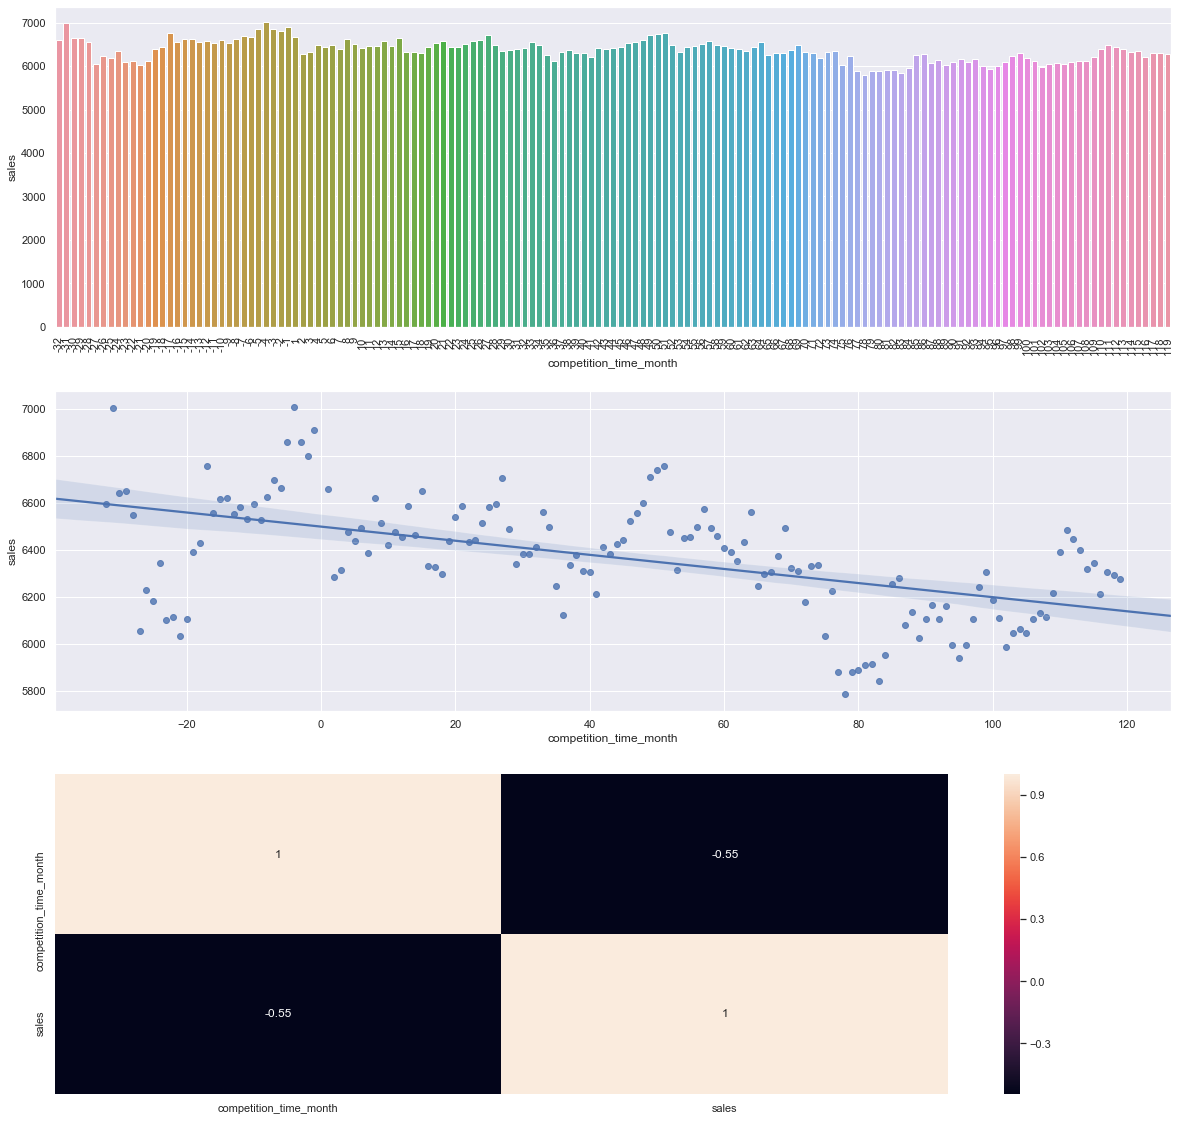

In [33]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]

plt.figure(figsize=[20,20])

plt.subplot(3,1,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales', data=aux2)

plt.subplot(3,1,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2);

plt.subplot(3,1,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**True**

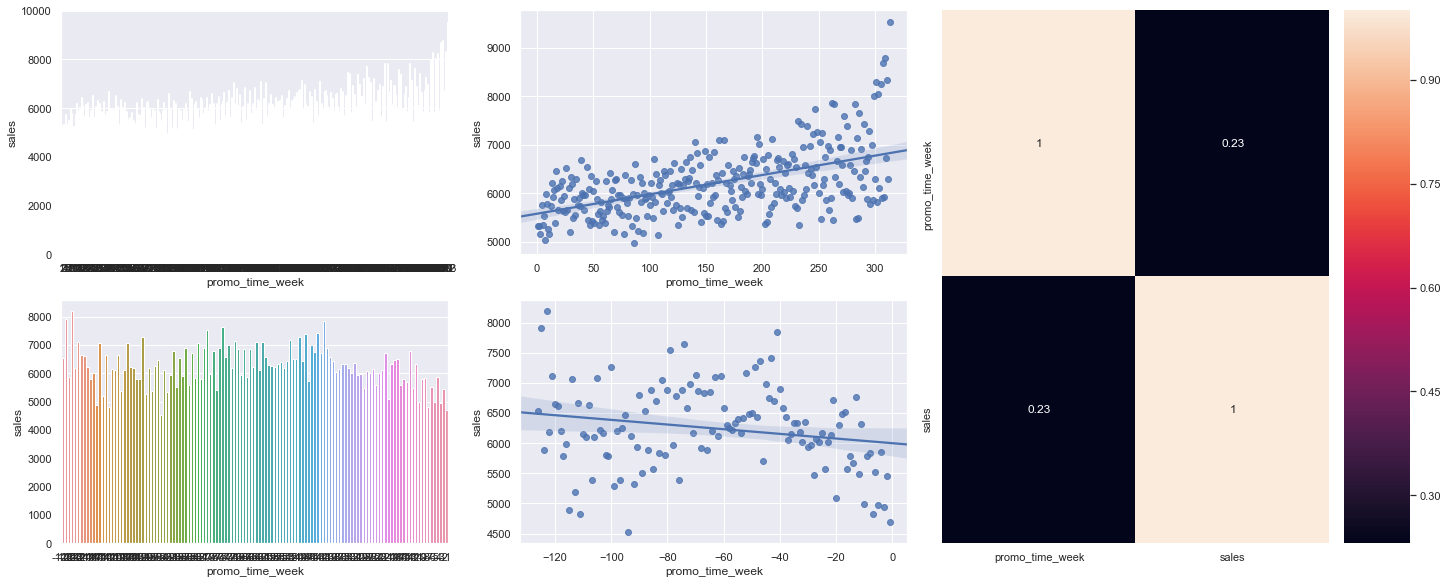

In [34]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').median().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]

fig = plt.figure(constrained_layout = True)
grid = fig.add_gridspec(2,3)

fig.add_subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2)

fig.add_subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

fig.add_subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3)

fig.add_subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

fig.add_subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s> H5. Lojas com mais dias de promoção deveriam vender mais. <s>

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem menos.

In [35]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757
1,0,1,5181
2,1,0,7950
3,1,1,7358


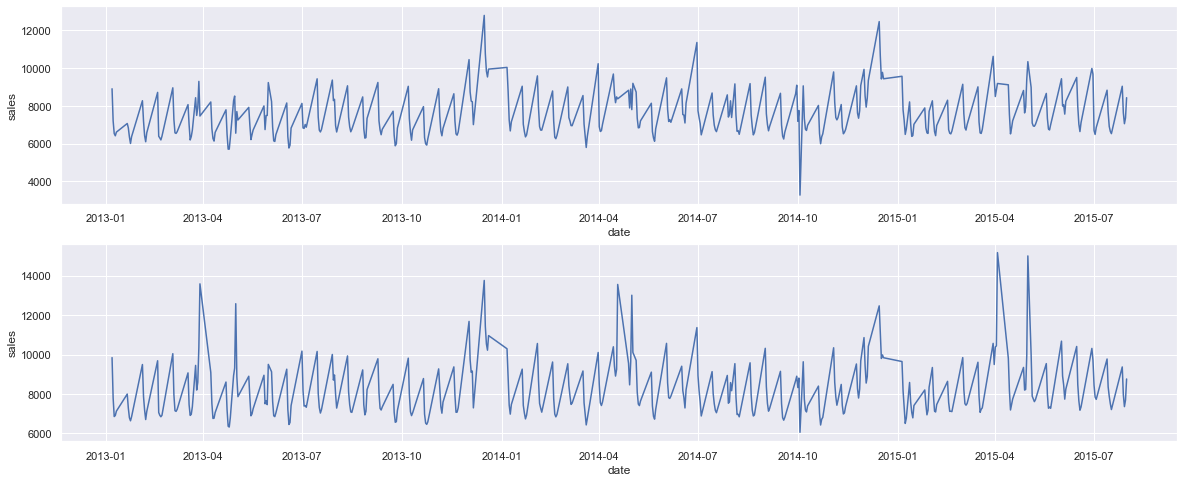

In [36]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['date','sales']].groupby('date').median().reset_index()
plt.subplot(2,1,1)
sns.lineplot(x='date',y='sales', data=aux1)

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0)][['date','sales']].groupby('date').median().reset_index()
plt.subplot(2,1,2)
sns.lineplot(x='date',y='sales', data=aux2);

#### H7. As vendas no natal deveriam ser maiores.
**True**

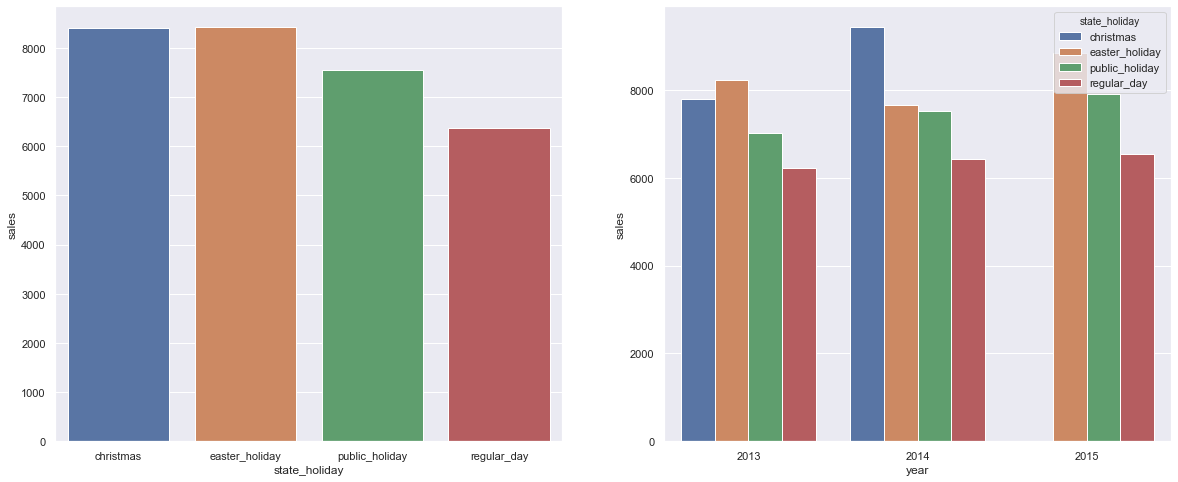

In [37]:
plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday',y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).median().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday', data=aux2);

#### H8. Lojas deveriam vender mais ao longo dos anos.
**True** A mediana de vendas do ano de 2014 é maior que 2013, porém a soma total de vendas é menor. Isso pode ser uma relação com a quantidade de registros de cada ano, ou seja, quantidade de dias abertos de 2014, pode ser menor que 2013. Validar no próximo ciclo.

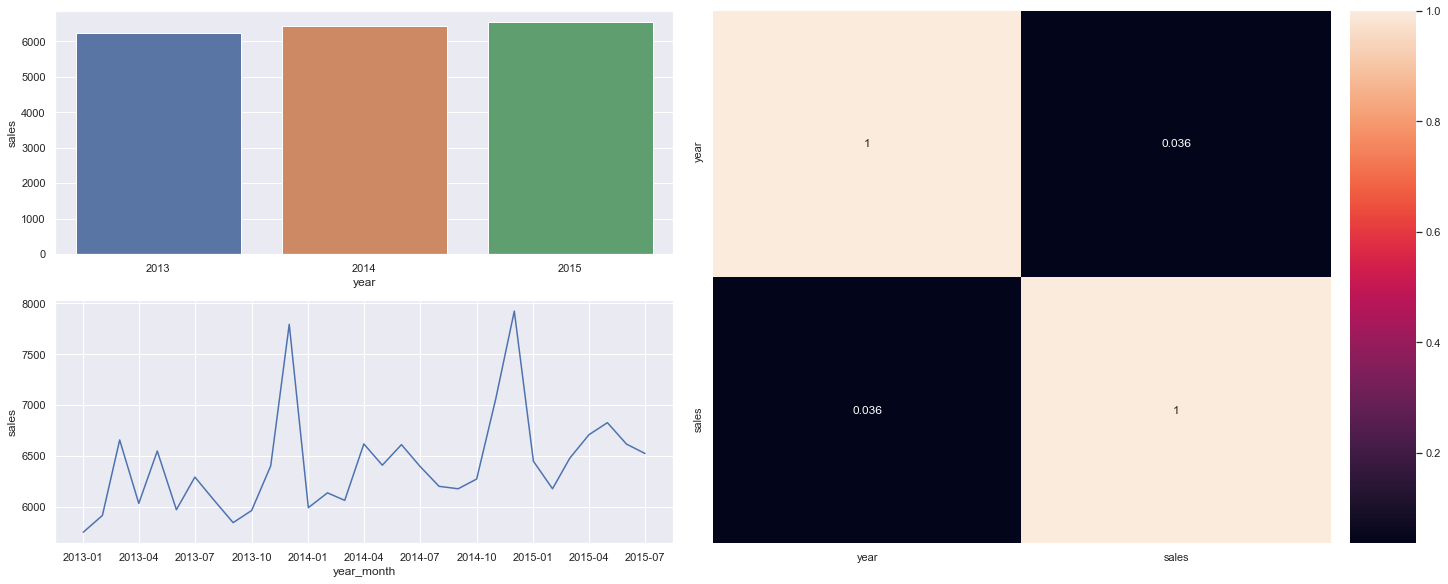

In [38]:
fig = plt.figure(constrained_layout = True)
grid = fig.add_gridspec(2,2)

fig.add_subplot(grid[0,0])
aux1 = df4[['year','sales']].groupby('year').median().reset_index()
sns.barplot(x='year',y='sales',data=aux1)

fig.add_subplot(grid[1,0])
aux2 = df4[['year','month','sales']].groupby(['year','month']).median().reset_index()
aux2['year_month'] = aux2.apply(lambda x: datetime.datetime(year=x['year'].astype('int64'), month=x['month'].astype('int64'), day=1), axis=1)
sns.lineplot(x='year_month',y='sales',data=aux2)

fig.add_subplot(grid[:,1])
sns.heatmap(df4[['year','sales']].corr(method='pearson'), annot=True);

#### H9. Lojas deveriam vender mais no segundo semestro do ano.
**True**

In [39]:
#aux1 = df4.copy()
#aux1['semester'] = aux1.apply(lambda x: 'first' if x['month'] < 6 else 'second', axis=1)
aux1 = df4[['month','sales']].groupby('month').median().reset_index()

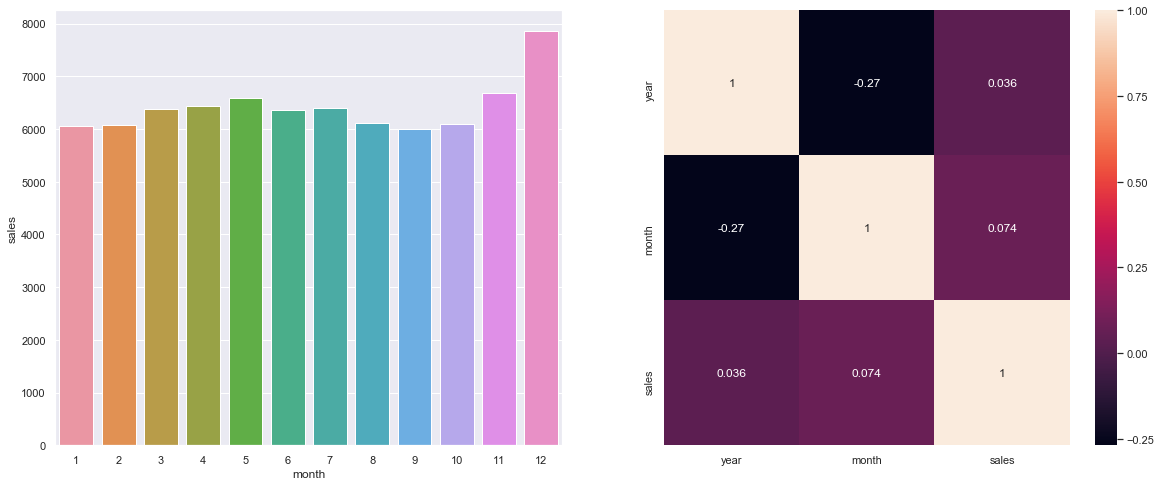

In [40]:
plt.subplot(1,2,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,2,2)
sns.heatmap(df4[['year','month','sales']].corr(method='pearson'), annot=True);

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**True**

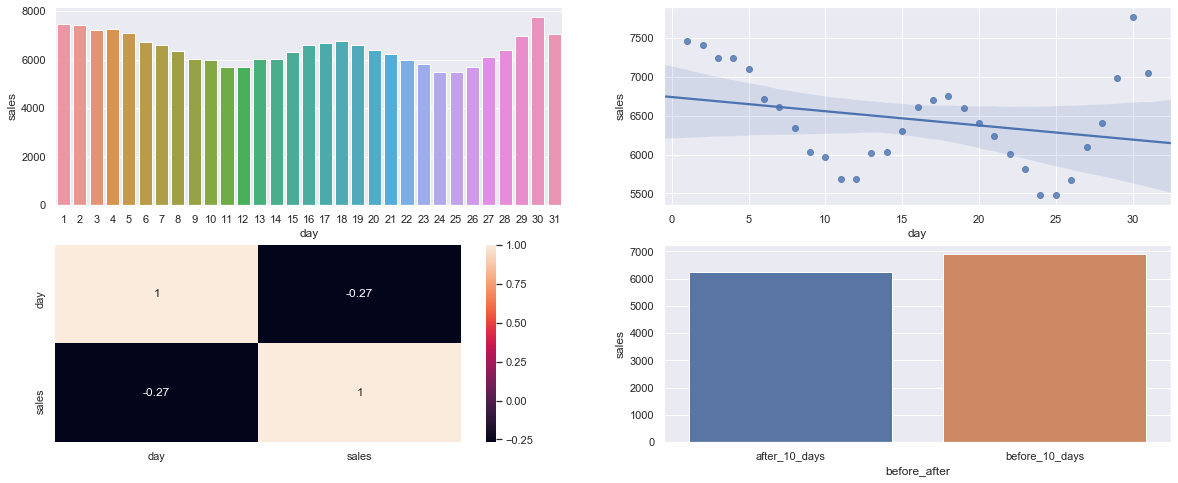

In [41]:
aux1 = df4[['day','sales']].groupby('day').median().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').median().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

#### H11. Lojas que abrem nos finais de semana deveriam vender menos.
**True**

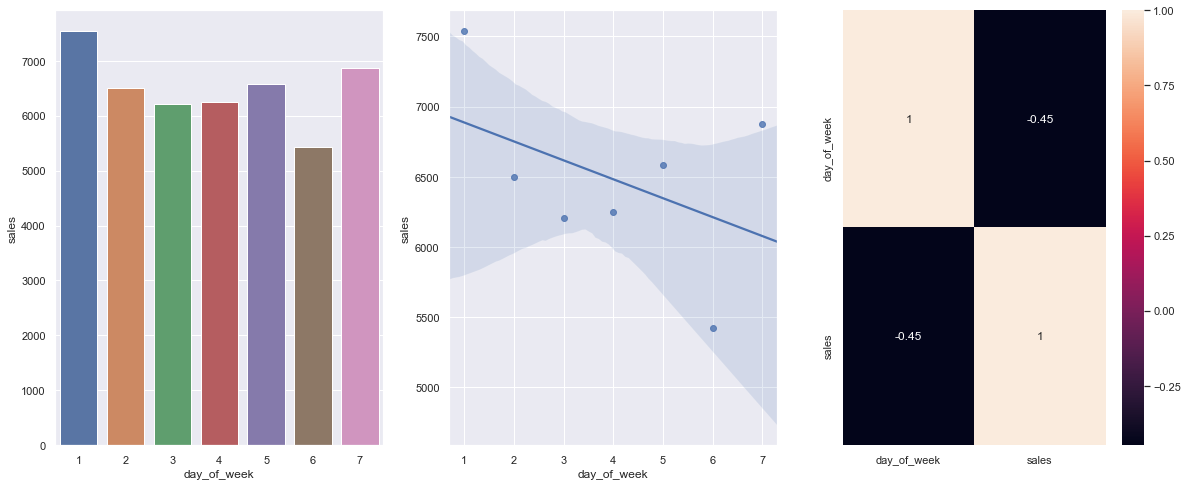

In [42]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').median().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H12. A soma das vendas em dias de feriado escolar devem ser menores que em dias normais.
**True**, exceto para os meses de julho e agosto.

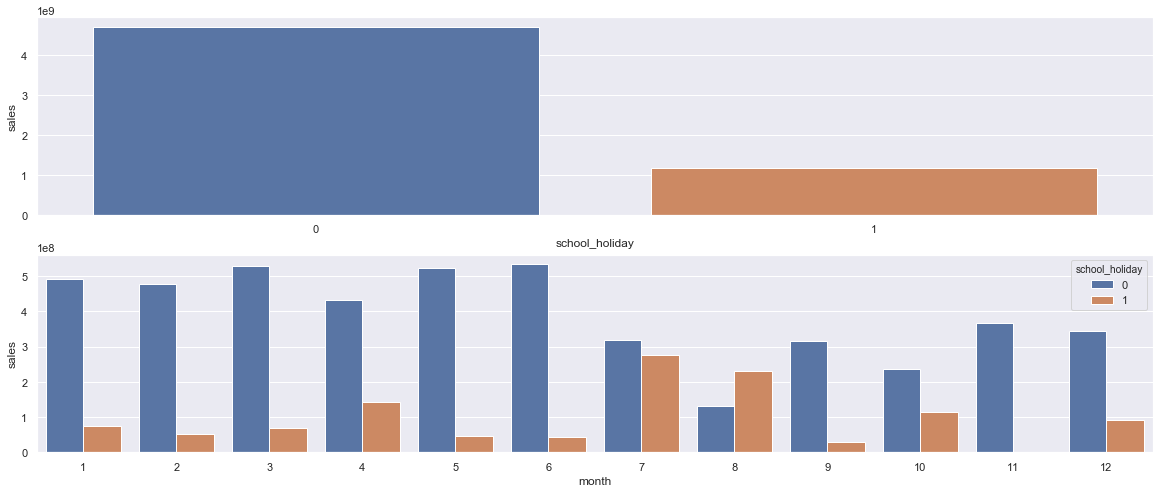

In [43]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);

### 4.2.2. Hypotheses Resume

In [44]:
tab = [['Hypotheses','Conclusion','Relevance'],
       ['H1','True','Baixa'],
       ['H2','False','Media'],
       ['H3','False','Media'],
       ['H4','True','Baixa'],
       ['H6','False','Baixa'],
       ['H7','True','Media'],
       ['H8','True','Alta'],
       ['H9','True','Alta'],
       ['H10','True','Alta'],
       ['H11','True','Alta'],
       ['H12','True','Baixa']]
print(tabulate(tab, headers='firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          Baixa
H2            False         Media
H3            False         Media
H4            True          Baixa
H6            False         Baixa
H7            True          Media
H8            True          Alta
H9            True          Alta
H10           True          Alta
H11           True          Alta
H12           True          Baixa


## 4.3. Multivariate Analisys

### 4.3.1 Numerical Attributes

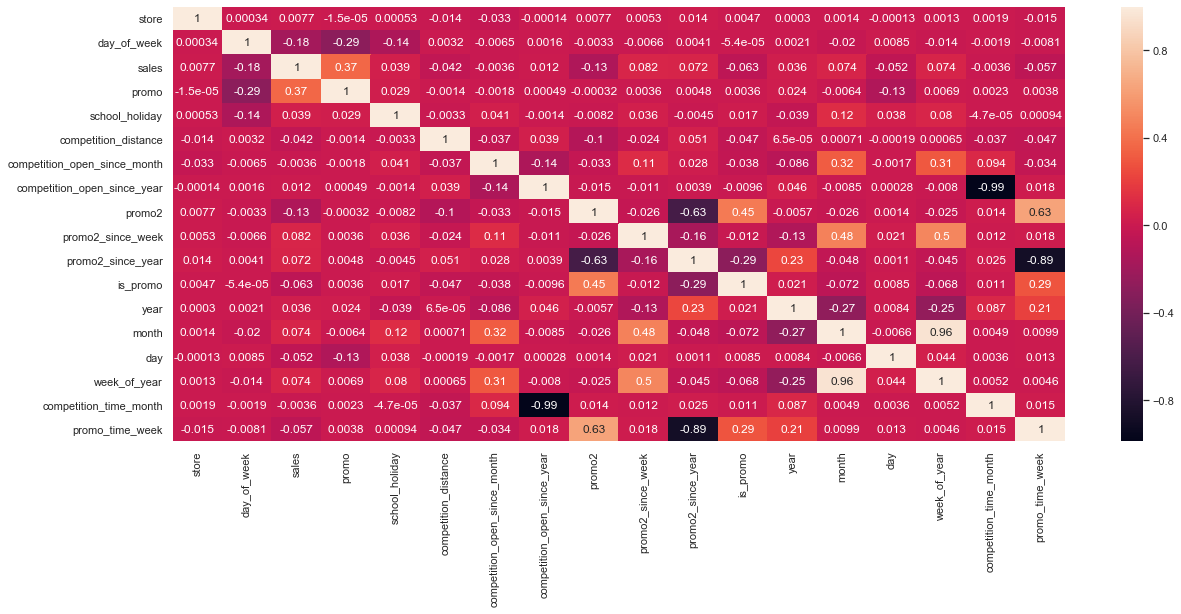

In [45]:
correlation = num_attributes2.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

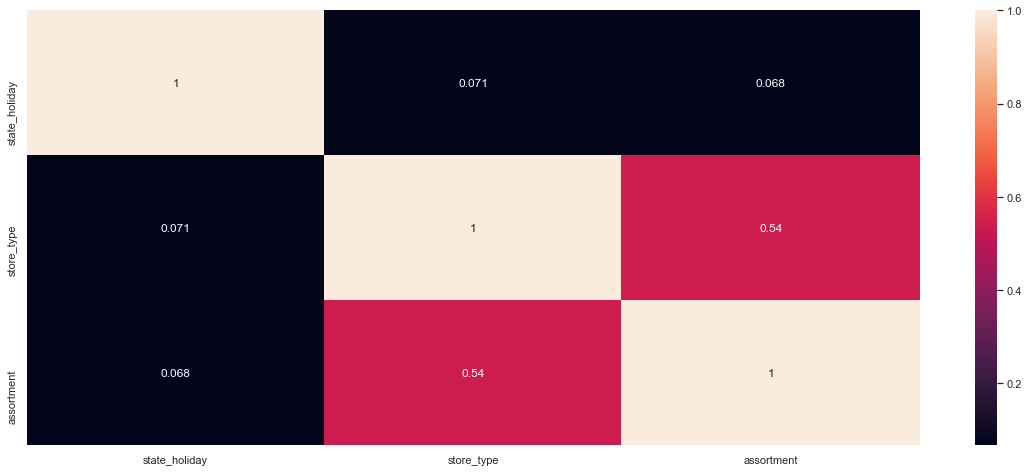

In [46]:
a = cat_attributes2.copy()

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0. DATA PREPARATION

In [27]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [29]:
mms = MinMaxScaler()
rs = RobustScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

## 5.3. Transformação

### 5.3.1 Encoding

In [30]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))

# assortment
assortment_map = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_map)

### 5.3.2 Response Variable Transformation

In [29]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [30]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))) 

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))) 

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))) 

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/54)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/54))) 

# 6.0. FEATURE SELECTION

In [48]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [49]:
cols_drop = ['month','day','week_of_year','day_of_week','promo_since','competition_since']
df6 = df6.drop(cols_drop, axis=1)

In [50]:
# Como nossas predições serão em relação as próximas 6 semanas, os dados de teste serão as ultimas 6 semanas registradas
## Devido ser uma predição temporal

#df6[['store','date']].groupby('store').min().reset_index() #First date

#df6[['store','date']].groupby('store').max().reset_index() #Last date

#df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) #First date of test

In [54]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training min date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test min date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training min date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test min date: 2015-07-31 00:00:00


## 6.2. Boruta Feature Selector

In [52]:
## training and test dataset boruta
#X_train_n = X_train.drop(['date','sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best features from Boruta

In [36]:
#cols_selected = boruta.support_.tolist()
#
## best features
#
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [37]:
#cols_selected_boruta

In [38]:
#cols_not_selected_boruta

In [39]:
print(tabulate(tab, headers='firstrow')) #inseir a coluna utilziada para validar a hipotese

NameError: name 'tab' is not defined

## 6.3. Manual Feature Selection

In [44]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

# final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [45]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. MACHINE LEARNING MODELING

In [57]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series validation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [44]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [44]:
x_test.drop(labels=['date','sales'], axis=1, inplace=True)

KeyError: "['date' 'sales'] not found in axis"

In [45]:
x_train.drop(labels=['date','sales'], axis=1, inplace=True)

KeyError: "['date' 'sales'] not found in axis"

In [46]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1864.292721,0.293871,2660.292326


### 7.2.1. Linear Regression Model CV

In [47]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

In [48]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2075.55+/-294.74,0.3+/-0.01,2949.35+/-463.59


## 7.3. Linear Regression Regularized Model - Lasso

In [49]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1862.907396,0.290732,2670.212808


### 7.3.1. Linear Regression Regularized Model - Lasso CV

In [50]:
lasso_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)

In [51]:
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.72+/-341.58,0.29+/-0.01,3057.96+/-504.86


## 7.4. Random Forest Regressor

In [52]:
# model
#rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit(x_train, y_train)
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42)
# prediction
#yhat_rf = rf.predict(x_test)

# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1. Random Forest Regressor CV

In [53]:
rf_result_cv = cross_validation(x_training, 5, 'Randon Forest Regressor', rf, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [55]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Randon Forest Regressor,838.79+/-221.98,0.12+/-0.02,1257.26+/-323.91


## 7.5. XGBoost Regressor

In [56]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, learning_rate=0.01, max_depth=10, 
                             subsample=0.7, colsample_bytree=0.9,booster='gbtree').fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.34089,0.949422,7330.611503


### 7.5.1. XGBoost Regressor CV

In [91]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [92]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.09+/-588.66,0.95+/-0.0,7715.15+/-689.64


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [58]:
modeling_results = pd.concat([lr_result, lrr_result, rf_result, xgb_result])
modeling_results

NameError: name 'rf_result' is not defined

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modeling_results_cv = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])
modeling_results

# 8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [84]:
param = {
    'n_estimators': [1500,1700,2500,3000,3500],
    'eta': [0.01,0.03],
    'max_depth': [3,5,9],
    'subsample': [0.1,0.5,0.7],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight': [3,8,15]
    }

MAX_EVAL = 10

In [ ]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: rd.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'], 
                                 subsample = hp['subsample'], 
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])
    
    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


## 8.2. Final Model

In [47]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
    }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators = 3000,
                                   eta = 0.03,
                                   max_depth = 5, 
                                   subsample = 0.7, 
                                   colsample_bytree = 0.7,
                                   min_child_weight = 3).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned)) 
xgb_result_tuned

# 9.0. PASSO 9 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO DE NEGÓCIO

In [58]:
# load pickle model
model_xgb_tuned = pickle.load(open('model/model_rossman.pkl','rb'))

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [59]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [78]:
# sum of predictions by store
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','predictions']].groupby('store').count().reset_index().rename(columns={'predictions':'count_predict'})
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store')

df9_aux3['Total_MAE'] = df9_aux3['MAE'] * df9_aux3['count_predict']

df9_aux3.drop(labels=['count_predict'], inplace=True, axis=1)

# MAPE
df9_aux4 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux5 = pd.merge(df9_aux3, df9_aux4, how='inner', on='store')

In [82]:
df92 = pd.merge(df91, df9_aux5, how='inner', on='store')

In [85]:
# created scenarios
df92['worst_scenario'] = df92['predictions'] - df92['Total_MAE']
df92['best_scenario'] = df92['predictions'] + df92['Total_MAE']

# order
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','Total_MAE','MAPE']]

In [110]:
# worst stores top10
df92.sort_values('MAPE', ascending=False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,Total_MAE,MAPE
291,292,103897.32031,41801.98682,165992.65381,3268.17545,62095.33350,0.54553
908,909,241842.64062,70686.16357,412999.11768,7441.58596,171156.47705,0.50521
875,876,203140.59375,112174.25073,294106.93677,3955.05839,90966.34302,0.30705
273,274,190990.67188,127444.47778,254536.86597,1477.81847,63546.19409,0.25714
721,722,350411.12500,279296.01318,421526.23682,1922.03005,71115.11182,0.25501
781,782,219145.10938,191209.14893,247081.06982,755.02596,27935.96045,0.22453
594,595,409907.65625,290553.83008,529261.48242,3225.77909,119353.82617,0.22090
533,534,282450.03125,234100.26074,330799.80176,1306.75055,48349.77051,0.20587
674,675,146469.85938,122383.94556,170555.77319,650.97064,24085.91382,0.20404
529,530,236929.25000,172516.13013,301342.36987,1497.97953,64413.11987,0.20237


In [111]:
# best stores top10
df92.sort_values('MAPE', ascending=True).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,Total_MAE,MAPE
989,990,233418.85938,222551.38916,244286.32959,293.71541,10867.47021,0.04555
1088,1089,372941.96875,353308.47021,392575.46729,530.63510,19633.49854,0.05074
258,259,529023.25000,499233.36328,558813.13672,692.78806,29789.88672,0.05301
1097,1098,188309.00000,178308.43042,198309.56958,270.28566,10000.56958,0.05533
666,667,311401.06250,292761.30273,330040.82227,503.77729,18639.75977,0.05550
762,763,225032.29688,211933.97559,238130.61816,354.00868,13098.32129,0.05594
732,733,623541.37500,588169.21289,658913.53711,822.60842,35372.16211,0.05643
634,635,211595.37500,199629.14453,223561.60547,323.41163,11966.23047,0.05774
741,742,294148.56250,276840.00049,311457.12451,467.79897,17308.56201,0.05807
5,6,171823.59375,162462.01465,181185.17285,253.01565,9361.57910,0.05831


In [87]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,Total_MAE,MAPE
511,512,265249.093750,240442.783203,290055.404297,576.890943,24806.310547,0.082530
500,501,185431.765625,168158.214844,202705.316406,466.852724,17273.550781,0.116380
1038,1039,338276.125000,291258.526367,385293.723633,1270.745909,47017.598633,0.165379
175,176,192136.281250,176184.286377,208088.276123,431.134997,15951.994873,0.096820
879,880,276825.843750,244225.663086,309426.024414,881.085964,32600.180664,0.103298


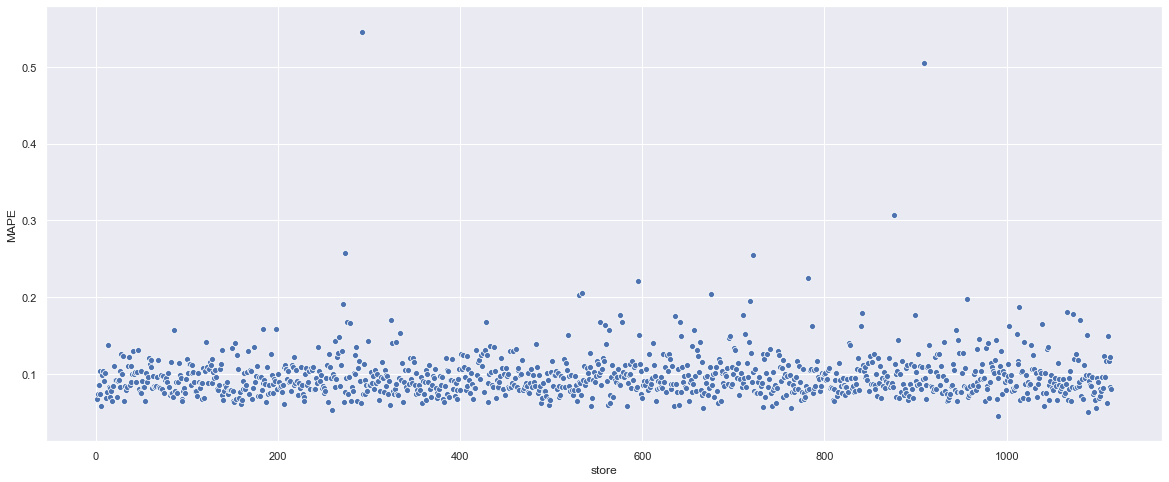

In [92]:
sns.scatterplot(x='store',y='MAPE',data=df92);

In [116]:
df92['MAPE'].describe()

count   1115.00000
mean       0.09720
std        0.03152
min        0.04555
25%        0.08031
50%        0.09137
75%        0.10640
max        0.54553
Name: MAPE, dtype: float64

## 9.2. Total Performance

In [105]:
# total performance by scenarios
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'scenarios', 0:'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

,scenarios,values
0,predictions,"R$282,954,840.45"
1,worst_scenario,"R$255,429,264.00"
2,best_scenario,"R$310,480,416.91"


## 9.3. Machine Learning Performance

In [106]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

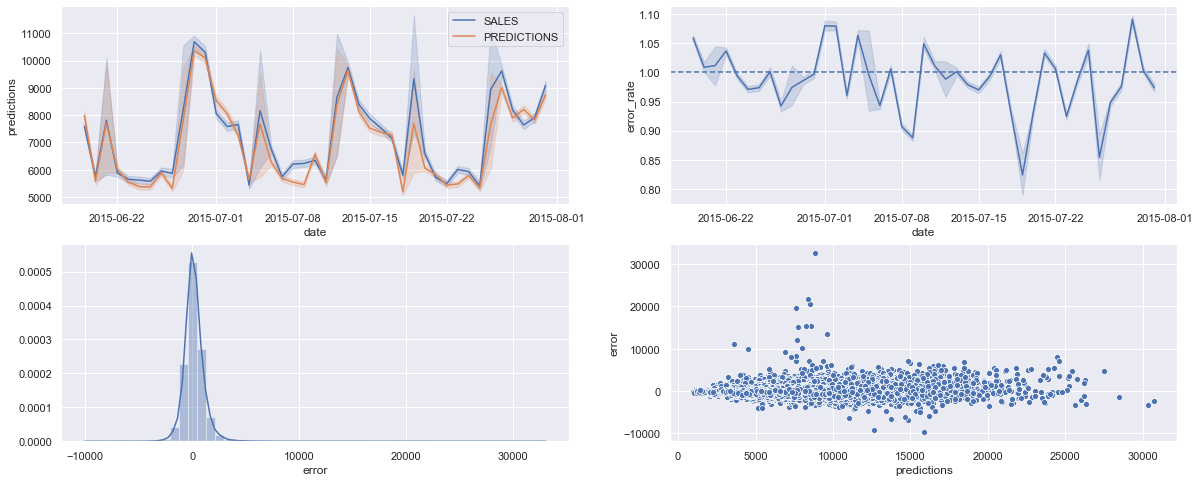

In [109]:
# predict and sales graph
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9, label='SALES')
sns.lineplot(x='date',y='predictions',data=df9, label='PREDICTIONS')

# overestimation and underestimation graph
plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1, linestyle='--')

# error distribuition
plt.subplot(2,2,3)
sns.distplot(df9['error'])

# residual graph
plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. PASSO 10 - DEPLOY MODEL IN PRODUCTION

In [53]:
# save trained model
pickle.dump(model_xgb_tuned, open('model/model_rossman.pkl','wb'))

In [ ]:
# load pickle model
model_xgb_tuned = pickle.load(open('model/model_rossman.pkl','rb'))

## 10.1. Rossman Class

In [21]:
class Rossman (object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl','rb'))
        self.store_type_scaler =             pickle.load(open('parameter/scaler_store_type.pkl','rb'))

    def data_cleaning(self, df1):
        
        ## 1.1 Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new
        
        ## 1.2 Data types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        #competition_distance
        # Assumimos uma assumption, onde farmacias que não contem competidor proximo, ao inves de retornar um valor NaN, retornar uma distancia maior que o valor max
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        # Se o valor == NaN, quer dizer que ou a loja nao tem competidores ou não tem uma data de registro de abertura da competição
        # Assumption: será inserido o mês e o ano da data de registro da venda, pois na avaliação do algoritmo, esse atributo pode ser importantes para responder a alta ou baixa no valor de venda, nesse sentido, vamos assumir essa premissa para analisar os resultados
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo_since_week'] = df1['promo_since_week'].astype(int)        
        df1['promo_since_year'] = df1['promo_since_year'].astype(int) 
        
        return df1
    
    def feature_engineering(self, df2):

        #year
        df2['year'] = df2['date'].dt.year
        #month
        df2['month'] = df2['date'].dt.month
        #day
        df2['day'] = df2['date'].dt.day
        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        #year week
        #df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

        #assortments
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTERING VARIABLES
        ## 3.1. Filtering rows
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2. Filtering columns
        cols_drop = ['customers','open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. Transformação
        ### 5.3.1 Encoding

        # state_holiday
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit(df5['store_type'])

        # assortment
        assortment_map = {'basic': 1, 'extra': 2, 'extended': 3 }
        df5['assortment'] = df5['assortment'].map(assortment_map)

        ### 5.3.2 Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))) 

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))) 

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))) 

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/54)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/54)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                         'month_cos', 'month_sin', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos',
                         'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]

## 10.2. API Handler

In [ ]:
import pandas as pd
import pickle
from flask           import Flask, request, Response
from rossman.Rossman import Rossman

# Loading model

model = pickle.load(open('/Users/Arbo/repos/my_git/rossman-predict-sales/model.pkl', 'rb'))

app = Flask(__name__)

#Método post, o usuário envia dados para receber outros
#Método Get, osuário solicita algo para receber

@app.route('/rossman/predict', method=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json: #há dados?
        if isinstace(test_json, dict): #Unique data
            test_raw = pd.DataFrame(test_jason, index=[0])
        
        else: #Multi data
            rest_raw = pd.DataFrame(test_json, columns=test_jason[0].keys())
    
    # Instantiate Rossman Class
    pipeline = Rossman()
    
    # Data cleaning
    df1 = pipeline.data_cleaning(test_raw)
    
    # Feature engineering
    df2 = pipeline.feature_engineering(df1) 
    
    # Data preparation
    df3 = pipeline.data_preparation(df2)
    
    #Prediction
    df_response = pipeline.get_prediction(model, test_raw, df3)
    
    return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

    
if __name__ == '__main__'
    app.run('0.0.0.0')
    
    

## 10.3. API Tester

In [ ]:
import requests

In [11]:
# Loading dataset test
df10 = pd.read_csv('data/test.csv')

In [14]:
# merge
df_test = pd.merge(df10, ####, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove columns 
df_test = df_test[df_test['open'] != 0]
df_test = df_test[~df_test['open'].isnull()]
df_test = df_test.drop('Id', axis=1)

MemoryError: Unable to allocate array with shape (5, 37115088) and data type int64

In [ ]:
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
# API call

url = 'http://0.0.0.0:5000/rossman/predict'
header = {'Content-type': 'appication/json'}

r = requests.post(url, data=data, headers=header)
print('Status code {}'.format(r.status_code))